In [346]:
import pandas as pd
import numpy as np
import altair as alt
import glob
import os
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from scipy.signal import butter, filtfilt
import altair as alt
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal
import pywt
from scipy.stats import wilcoxon
import matplotlib.cm as cm


alt.data_transformers.disable_max_rows()
fs = 22050

### Definitions

#### Analysis definitions

In [347]:
def load_data(subjid):
    # example 'hydrolagusColliei_8'
    loaded = np.load(f'/mnt/c/Users/seaudlab/Documents/hydroC/{subjid}_data.npz', allow_pickle=True) # Aoi
    #loaded = np.load(f'{subjid}_data.npz', allow_pickle=True)
    data = loaded['data']
    freq_amp_table = loaded['freq_amp_table']
    latency = loaded['latency'].item()
    channel_keys = loaded['channel_keys'].tolist()
    period_keys = ['prestim','stimresp']
    metric_keys = ['mean','std']
    submetric_keys = ['doub_freq_mag','SNR']
    
    return data, freq_amp_table, latency, channel_keys, period_keys, metric_keys, submetric_keys


In [348]:
def remove_artefacts(data):
    for coord, dictionary in data.item().items():
        for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
            rms_per_row = np.sqrt(np.mean(dictionary[channel]**2, axis=1))  # Get RMS of each row, axis = 1 means collapse rows
            rms_mean = np.mean(rms_per_row)
            rms_std = np.std(rms_per_row)
            
            # See which rows has an rms that is too high (i.e., artifact) and remove them
            threshold = rms_mean + (rms_std*3)
            keep_rows = rms_per_row <= threshold
            dictionary[channel] = dictionary[channel][keep_rows]
            dictionary[f'{channel}_total_trials'] = dictionary[channel].shape[0]
    
    for coord, dictionary in data.item().items():
        # Determine the minimum number of trials across all channels
        min_trials = min([dictionary[f'{channel}_total_trials'] for channel in ['ch1', 'ch2', 'ch3', 'ch4']])
        
        # Randomly select the same number of trials for each channel
        for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
            # Set a random seed for reproducibility if needed
            np.random.seed(42)
            
            # Get indices for the channel
            channel_indices = np.arange(dictionary[channel].shape[0])
            
            # Randomly select indices
            selected_indices = np.random.choice(channel_indices, size=min_trials, replace=False)
            
            # Update the channel data with selected trials
            dictionary[channel] = dictionary[channel][selected_indices]
            
            # Update the total trials count
            dictionary[f'{channel}_total_trials'] = min_trials
    
    return data

In [349]:
def select_stimulus(data, myfreq, myamp):
    specific_key = (np.float64(myfreq), np.float64(myamp))
    current_cond = data.item()[specific_key]
    
    return current_cond

In [350]:
def add_weights(data, channel_keys, weights):
    weighted_data = {}
    for idx, channel in enumerate(channel_keys):
        current_data = data[channel]
        current_weight = weights[idx]
        weighted_data[channel] = current_data * current_weight
    return weighted_data

In [351]:
def separate_periods(data, current_cond, period_keys, channel_keys, latency):
    separated_data = {
        'prestim': {},
        'stimresp': {}
    }
    
    period_len = current_cond['period_len']
    
    for period in period_keys:
        for channel in channel_keys:            
            if period == 'prestim':
                separated_data[period][channel] = data[channel][:,latency:latency+period_len]     
            elif period == 'stimresp':
                separated_data[period][channel] = data[channel][:,latency+period_len:latency+period_len*2]
                
    return separated_data

In [352]:
def calculate_per_trial_diff(data, channel_keys):
    diffs = []
    for channel in channel_keys:
        prestim = data['prestim'][channel]
        stimresp = data['stimresp'][channel]
        diffs.append(stimresp-prestim)
    diffs = np.vstack(diffs)
    return diffs

In [353]:
def compute_welch_fft(data, period_keys, channel_keys, fs, nperseg=fs, normalize=False):
    from scipy.signal import welch
    import numpy as np
    
    # Initialize dictionaries with nested structure
    per_period_welch = {period: {} for period in period_keys}
    per_period_welch_freq = {period: {} for period in period_keys}
    
    for period in period_keys:
        for channel in channel_keys:
            trial_magnitudes = []
            freq_vecs = []
            num_trial = data[period][channel].shape[0]
            
            for trial in range(num_trial):
                cur_trial = data[period][channel][trial]
                
                # Use standard FFT length calculation
                freq_vec, Pxx = welch(
                    cur_trial, 
                    fs=fs, 
                    nperseg=nperseg, 
                    scaling='spectrum'
                )
                
                # Normalize if requested
                if normalize:
                    Pxx = Pxx / np.max(Pxx)
                
                trial_magnitudes.append(Pxx)
                freq_vecs.append(freq_vec)
                
            per_period_welch[period][channel] = np.vstack(trial_magnitudes)
            per_period_welch_freq[period][channel] = np.vstack(freq_vecs)
    
    # Return both dictionaries
    return per_period_welch, per_period_welch_freq

In [354]:
def compute_fft(data, channel_keys, period_keys,smallest_dim, fs):
    # No channels or periods
    if len(period_keys) == 0 and len(channel_keys) == 0:
        fft_magnitudes = {}
        fft_freq_vecs = {}
        
        trial_magnitudes = []
        freq_vecs = []
        
        if smallest_dim == 1:
            num_cols = data.shape[smallest_dim]
            for trial in range(num_cols):
                cur_trial = data[:,trial]
                n_samples = len(cur_trial)
                # Calculate frequencies for positive frequencies only
                freqs = np.fft.rfftfreq(fs, d=1/fs)
                
                # Calculate magnitude spectrum
                fft_vals = np.fft.rfft(cur_trial,fs)
                magnitude = np.abs(fft_vals)/n_samples
                
                trial_magnitudes.append(magnitude)
                freq_vecs.append(freqs)
                    
                fft_magnitudes = np.vstack(trial_magnitudes)
                fft_freq_vecs = np.vstack(freq_vecs)
    
    # Only have channels        
    elif len(period_keys) == 0 and len(channel_keys) > 0:
        # Initialize dictionaries with nested structure
        fft_magnitudes = {}
        fft_freq_vecs = {}
        
        for channel in channel_keys:
            trial_magnitudes = []
            freq_vecs = []
            num_trial = min(data[channel].shape)
            for trial in range(num_trial):
                cur_trial = data[channel][trial]
                n_samples = len(cur_trial)
                # Calculate frequencies for positive frequencies only
                freqs = np.fft.rfftfreq(fs, d=1/fs)
                
                # Calculate magnitude spectrum
                fft_vals = np.fft.rfft(cur_trial,fs)
                magnitude = np.abs(fft_vals)/n_samples
                
                trial_magnitudes.append(magnitude)
                freq_vecs.append(freqs)
                
            fft_magnitudes[channel] = np.vstack(trial_magnitudes)
            fft_freq_vecs[channel] = np.vstack(freq_vecs)
    
    # Have both period and channel delination
    elif len(period_keys) > 0 and len(channel_keys) > 0: 
        # Initialize dictionaries with nested structure
        fft_magnitudes = {period: {} for period in period_keys}
        fft_freq_vecs = {period: {} for period in period_keys}
        
        for period in period_keys:
            for channel in channel_keys:
                trial_magnitudes = []
                freq_vecs = []
                num_trial = data[period][channel].shape[0]
                
                for trial in range(num_trial):
                    cur_trial = data[period][channel][trial]
                    n_samples = len(cur_trial)
                    # Calculate frequencies for positive frequencies only
                    freqs = np.fft.rfftfreq(fs, d=1/fs)
                    
                    # Calculate magnitude spectrum
                    fft_vals = np.fft.rfft(cur_trial,fs)
                    magnitude = np.abs(fft_vals)/n_samples
                    
                    trial_magnitudes.append(magnitude)
                    freq_vecs.append(freqs)
                    
                fft_magnitudes[period][channel] = np.vstack(trial_magnitudes)
                fft_freq_vecs[period][channel] = np.vstack(freq_vecs)
    
    # Return both dictionaries
    return fft_magnitudes, fft_freq_vecs

In [355]:
def calc_dpss(data, fs, period_keys, channel_keys):
    import nitime.algorithms as tsa
    # Initialize dictionaries with nested structure
    per_period_fft = {period: {} for period in period_keys}
    per_period_fft_freq = {period: {} for period in period_keys}
    
    for period in period_keys:
        for channel in channel_keys:
            trial_magnitudes = []
            freq_vecs = []
            num_trial = data[period][channel].shape[0]
            
            for trial in range(num_trial):
                cur_trial = data[period][channel][trial]
                f, psd, nu = tsa.multi_taper_psd(cur_trial,Fs=fs) # nu = df
                
                trial_magnitudes.append(psd)
                freq_vecs.append(f)
                
            per_period_fft[period][channel] = np.vstack(trial_magnitudes)
            per_period_fft_freq[period][channel] = np.vstack(freq_vecs)
    return per_period_fft, per_period_fft_freq

In [356]:
def calc_grand_average(data, period_keys, channel_keys):
    grand_average = {period: {} for period in period_keys}
    grand_std = {period: {} for period in period_keys}
    for period in period_keys: 
        for channel in channel_keys:
            cur_data = data[period][channel]
            cur_avg = np.mean(cur_data, axis=0)
            cur_std = np.std(cur_data, axis=0)
            grand_average[period][channel] = cur_avg
            grand_std[period][channel]=cur_std
    
    grand_data = {
        'average': grand_average,
        'std' : grand_std
    }
    return grand_data

In [357]:
def plot_fft_grand_mean(grand_data, period_keys, channel_keys, title_prefix='', xlim=None):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create a figure with subplots for each period
    fig, axes = plt.subplots(len(period_keys), len(channel_keys), 
                              figsize=(5*len(channel_keys), 4*len(period_keys)), 
                              squeeze=False)
    
    for period_idx, period in enumerate(period_keys):
        for channel_idx, channel in enumerate(channel_keys):
            ax = axes[period_idx, channel_idx]
            
            # Get average and standard deviation
            avg = grand_data['average'][period][channel]
            std = grand_data['std'][period][channel]
            
            # Assuming the frequency vector is passed in or needs to be created
            # This might need adjustment based on how your frequency vector is stored
            freq_vec = np.linspace(0, len(avg), len(avg))
            
            # Plot the mean line
            ax.plot(freq_vec, avg, label='Mean')
            
            # Add shaded standard deviation area
            ax.fill_between(freq_vec, 
                            avg - std, 
                            avg + std, 
                            alpha=0.3, 
                            label='±1 Std Dev')
            
            # Set x-axis limits if provided
            if xlim is not None:
                ax.set_xlim(xlim)
            
            # Formatting
            ax.set_title(f'{title_prefix}{period} - {channel}')
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Power')
            ax.legend()
    
    plt.tight_layout()
    return fig

In [358]:
def find_large_stds(data, freq_vecs, period_keys, channel_keys, metric_keys, myfreq):
    my_rat_data = {}
    my_SNR_data = {}
    target_freq = myfreq*2
    for channel in channel_keys.copy():
        my_rat_data[channel] = []
        cur_avg = data['average']['stimresp'][channel]
        print(len(cur_avg))
        cur_std = data['std']['stimresp'][channel]
        cur_freq_vec = freq_vecs['stimresp'][channel][0]
        
        # Double frequency mask (3 Hz tolerance)
        doub_mask = np.abs(cur_freq_vec - target_freq) <= 3
        my_mean = cur_avg[doub_mask]
        my_std = cur_std[doub_mask]
        my_rat = my_std/my_mean
        my_rat_data[channel].append(my_rat)
        
        print(f"{channel} : {my_rat}")
    
        if my_rat > 6:
            print(f"Warning {channel} has super high std value")
            
    filt_channel_keys = channel_keys

    return my_rat_data, filt_channel_keys

In [454]:
def calculate_diff_CI(data, submetric):
    prestim = data['prestim'][submetric]
    stimresp = data['stimresp'][submetric]
    diff = stimresp - prestim

    # 2. Compute 95% confidence interval for the difference
    lower = float(np.percentile(diff, 2.5))
    upper = float(np.percentile(diff, 97.5))

    print("95% CI:", (lower, upper))

    # 3. Decision rule: if CI excludes 0 → significant
    if lower > 0 or upper < 0:
        print("Groups differ significantly (CI excludes 0).")
    else:
        print("No significant difference (CI includes 0).")
    
    return [lower, upper]

In [359]:
def reshape_the_data(data, channel_keys):
    # Reshape to channel x (trials x samples)
    
    reshaped_list = []
    for channel in channel_keys:
        cur_set = data[channel]
        reshaped_list.append(cur_set.reshape(-1, 1))
    
    reshaped_data = np.hstack(reshaped_list)
    return reshaped_data

In [360]:
def perform_ICA(data, channel_keys):
    start = time.perf_counter()
    
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Improved FastICA configuration
    ica = FastICA(
        n_components=len(channel_keys), 
        random_state=42,  # More robust random seed
        max_iter=500,     # Increased iterations
        tol=1e-4,         # Tightened tolerance???
        whiten='unit-variance'  # Corrected whiten parameter
    )
    
    S = ica.fit_transform(data_scaled)
    A = ica.mixing_

    end = time.perf_counter()
    elasped = end - start
    
    # Convergence check
    print(f"Elapsed time: {elasped:.2f} seconds")
    print(f"ICA Convergence: {ica.n_iter_}")
    
    # Store results in dictionary
    ica_results = {
        'S': S,
        'A': A,
        'n_iter': ica.n_iter_,
        'elapsed_time': elasped
    }
    
    return ica_results

In [361]:
def select_doub_freq_bin(data, frequencies, period_keys, myfreq, window_size=100):
    doub_freq_dict = {
        'prestim': {},
        'stimresp': {}
    }
        
    target_freq = 2*myfreq
    part_window = window_size/2
    artifact_freqs = [myfreq, target_freq, 60, 120, 180, 240, 300, 360, 420, 480, 540]
    freq_vec = frequencies['prestim']['ch1']
        
    # Double frequency mask (3 Hz tolerance)
    doub_mask = np.abs(freq_vec - target_freq) <= 3
    print(doub_mask.shape)
    window_mask = (freq_vec >= target_freq-part_window) & (freq_vec <= target_freq+part_window)
       
    for freq in artifact_freqs:
        art_mask = np.abs(freq_vec - freq) <= 3
        window_mask[art_mask] = False
        
    num_it = len(data['prestim'])
    doub_mask = doub_mask[0]
    window_mask = window_mask[0]
    
    print(num_it)
    for period in period_keys:
        doub_freq_tmp = []
        snr_tmp = []
        for cur_it in range(num_it):
            cur_data = data[period][cur_it]
            doub_mag = cur_data[doub_mask]
            remain_mag = cur_data[window_mask]
            
            doub_mag = np.mean(doub_mag)
            remain_mag = np.sum(remain_mag)
            
            doub_freq_tmp.append(doub_mag)
            snr_tmp.append(10 * np.log10((doub_mag) / (remain_mag)))
        
        # Move this inside the period loop
        doub_freq_dict[period] = {
            'doub_freq_mag': np.hstack(doub_freq_tmp),
            'SNR': np.hstack(snr_tmp)
        }
            
    return doub_freq_dict

In [362]:
def select_top_2_SNR(data):
    # doub_freq_ICA = data
    snr = data['SNR']
    top2_idx = np.argsort(snr)[-2:][::-1] 
    top2_idx

In [363]:
def remove_and_reconstruct_ica(ica_results, current_cond, channel_keys, components_to_keep, num_complete_groups):
    recon_restruct_data = {}
    
    # Extract ICA results
    S = ica_results['S']
    A = ica_results['A']
    
    # Create a mask to keep only desired components
    keep_mask = np.zeros(S.shape[1], dtype=bool)
    keep_mask[components_to_keep] = True
    
    # Filter independent components
    S_filtered = S[:, keep_mask]
    A_filtered = A[:, keep_mask]
    
    # Reconstruct the data
    reconstructed_data = np.dot(S_filtered, A_filtered.T)
    
    n_trials = num_complete_groups
    n_samples_per_trial = current_cond['ch1'].shape[1]
    
    for idx, channel in enumerate(channel_keys):
        recon_restruct_data[channel] = reconstructed_data[:, idx].reshape(n_trials, n_samples_per_trial)  
    
    return recon_restruct_data, reconstructed_data

In [364]:
def collapse_channels(data, period_keys, channel_keys):
    collapsed_dict = {
        'prestim': None,
        'stimresp': None
    }
    for period in period_keys:
        tmp = []
        for channel in channel_keys:
            tmp.append(data[period][channel])
        collapsed_dict[period] = np.vstack(tmp)
        
    return collapsed_dict

In [365]:
import numpy as np
from sklearn.utils import resample

def calculate_bootstrap(data, period_keys, n_iterations):
    boot_means = {
        'prestim': None,
        'stimresp': None
    }
    
    boot_std = {
        'prestim': None,
        'stimresp': None
    }
    
    for period in period_keys:
        cur_data = data[period]
        n_samples = len(cur_data)

        boot_means[period] = [
            np.mean(resample(cur_data, n_samples=n_samples), axis=0) 
            for _ in range(n_iterations)
        ]

        boot_std[period] = [
            np.std(resample(cur_data, n_samples=n_samples), axis=0) 
            for _ in range(n_iterations)
        ]
        
        # # Calculate confidence interval
        # CI_means = np.percentile(bootstrap_means, [2.5, 97.5])
        # CI_stds = np.percentile(bootstrap_stds, [2.5, 97.5])
        
    return boot_means, boot_std

#### Plotting definitions

In [378]:
def plot_waveforms(data, channel_keys, title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25):
    if len(channel_keys) == 0:
        num_row = data.shape[1]
        fig, axes = plt.subplots(num_row, 1, figsize=figsize, sharex=True, sharey=True)

        for row_idx in range(num_row):
            ax = axes[row_idx]
            current_data = data[:,row_idx]
            ax.plot(current_data, alpha=alpha)
            
    else:
        fig, axes = plt.subplots(len(channel_keys), 1, figsize=figsize, sharex=True, sharey=True)
        
        if len(channel_keys) == 1:
            axes = [axes]
        
        for row_idx, channel in enumerate(channel_keys):
            ax = axes[row_idx]
            current_data = data[channel]
            
            random_indices = np.random.choice(current_data.shape[0], 
                                            size=min(num_samples, current_data.shape[0]), 
                                            replace=False)
            
            for i in random_indices:
                ax.plot(current_data[i, :], alpha=alpha)
            
            ax.set_ylabel(channel)
    
    fig.suptitle(title)
    fig.tight_layout()
    
    return fig, axes

In [368]:
def plot_fft(magnitudes, frequencies, channel_keys, period_keys,myfreq, myamp, subjid, title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25,xlim=[]):
    if len(channel_keys) == 0:      
        print('nope')
    elif len(channel_keys) > 1 and len(period_keys) == 0:
        fig, axes = plt.subplots(len(channel_keys), 1, figsize=figsize, sharex=True, sharey=True)
        for row_idx, channel in enumerate(channel_keys):
            ax = axes[row_idx]
            cur_mag = magnitudes[channel]
            cur_freq = frequencies[channel]
            
            random_indices = np.random.choice(cur_mag.shape[0], 
                                            size=min(num_samples, cur_mag.shape[0]), 
                                            replace=False)
            
            for i in random_indices:
                ax.plot(cur_freq[i, :],cur_mag[i, :], alpha=alpha)
            
            ax.set_ylabel(channel)
            ax.set_xlim(xlim)
            
    elif len(channel_keys) > 0 and len(period_keys) > 0:
        fig, axes = plt.subplots(len(channel_keys), len(period_keys), figsize=figsize, sharex=True, sharey=True)
        
        for col_idx, period in enumerate(period_keys):
            for row_idx, channel in enumerate(channel_keys):
                ax = axes[row_idx,col_idx]
                cur_mag = magnitudes[period][channel]
                cur_freq = frequencies[period][channel]
                
                random_indices = np.random.choice(cur_mag.shape[0], 
                                                size=min(num_samples, cur_mag.shape[0]), 
                                                replace=False)
                
                for i in random_indices:
                    ax.plot(cur_freq[i, :],cur_mag[i, :], alpha=alpha)
                
                ax.set_ylabel(channel)
                ax.set_xlim(xlim)
    
    
    fig.suptitle(f"{subjid} {myfreq} Hz {myamp} dB: {title}")
    fig.tight_layout()
    plt.savefig(f"{subjid}_{myfreq}Hz_{myamp}dB_{title}.png", 
        format='png', 
        bbox_inches='tight', 
        dpi=300)
    return fig, axes

In [369]:
def plot_hist(data, subjid, channel_keys, submetric_keys, myfreq, myamp, bin_num):
    for submetric in submetric_keys:
        # Create the figure for each submetric
        fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True)
        
        # Iterate through channels
        for i, channel in enumerate(channel_keys):
            prestim = data['prestim'][channel][submetric]
            stimresp = data['stimresp'][channel][submetric]
            
            # Prestim (Stim OFF) histogram
            axes[i, 0].hist(prestim, 
                            bins=bin_num, edgecolor='black')
            axes[i, 0].set_title(f'{channel} Stim OFF - {submetric}')
            axes[i, 0].set_xlabel('Power')
            axes[i, 0].set_ylabel('Frequency')
            axes[i, 0].set_yscale('log')
            
            # Stimresp (Stim ON) histogram
            axes[i, 1].hist(stimresp, 
                            bins=bin_num, edgecolor='black')
            axes[i, 1].set_title(f'{channel} Stim ON - {submetric}')
            axes[i, 1].set_xlabel('Power')
            axes[i, 1].set_ylabel('Frequency')
            axes[i, 1].set_yscale('log')
        
        # Overall figure title
        fig.suptitle(f"{subjid} 2x Freq. Resp. {submetric} Comparison {myfreq}Hz {myamp}dB", 
                    fontsize=16)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save figure
        plt.savefig(f"{subjid}_2x_resp_hist_{submetric}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        
        # Show the plot and keep it open
        plt.show()

In [370]:
def plot_doub_freq_hist(doub_freq_dict, subjid, submetric, myfreq, myamp, bin_num):
    # Create the figure 
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot histograms for both periods
    ax.hist(doub_freq_dict['prestim'][submetric], 
            bins=bin_num, 
            alpha=0.5, 
            label='Stim OFF')
    ax.hist(doub_freq_dict['stimresp'][submetric], 
            bins=bin_num, 
            alpha=0.5, 
            label='Stim ON')
    
    ax.set_title(f"{subjid} {myfreq}Hz {myamp}dB")
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')
    ax.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f"{subjid}_2x_resp_hist_magnitude_{myfreq}Hz_{myamp}dB.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=300)
    
    # Show the plot and keep it open
    plt.show()

In [371]:
def plot_overlap_hist(data, subjid, channel_keys, submetric_keys, myfreq, myamp, bin_num):
    for submetric in submetric_keys:
        # Create the figure for each submetric
        fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True, sharey=True)
        
        # Iterate through channels
        for i, channel in enumerate(channel_keys):
            prestim = data['prestim'][channel][submetric]
            stimresp = data['stimresp'][channel][submetric]
            
            # Plot both histograms on the same subplot for Stim OFF
            axes[i].hist(prestim, 
                            bins=bin_num, 
                            alpha=0.5, 
                            label='Stim OFF')
            axes[i].hist(stimresp, 
                            bins=bin_num, 
                            alpha=0.5, 
                            label='Stim ON')
            axes[i].set_title(f'{channel} Comparison - {submetric}')
            axes[i].set_xlabel('Power')
            axes[i].set_ylabel('Frequency')
            axes[i].set_yscale('log')
            axes[i].legend()
        
        # Overall figure title
        fig.suptitle(f"{subjid} 2x Freq. Resp. {submetric} Comparison {myfreq}Hz {myamp}dB", 
                    fontsize=16)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save figure
        plt.savefig(f"{subjid}_2x_resp_hist_{submetric}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        
        # Show the plot and keep it open
        plt.show()

In [372]:
def plot_boxes(data, subjid, channel_keys, submetric_keys, myfreq, myamp):
    import numpy as np
    import matplotlib.pyplot as plt
    
    for submetric in submetric_keys:
        # Create the figure for each submetric
        fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True, sharey=True)
        
        # Iterate through channels
        for i, channel in enumerate(channel_keys):
            group1 = data['prestim'][channel][submetric]
            group2 = data['stimresp'][channel][submetric]
        
            # Create box plot with customized median line
            box_plot = axes[i].boxplot([group1, group2], positions=[0, 1], 
                                       patch_artist=True, 
                                       boxprops=dict(facecolor='lightblue'),
                                       medianprops=dict(
                                           color='red',      # Change color to red
                                           linewidth=2       # Make line thicker
                                       ))
            
            # Color the boxes individually
            for j, box in enumerate(box_plot['boxes']):
                box.set_facecolor('lightblue' if j == 0 else 'orange')
            
            # Customize the plot
            axes[i].set_title(f'{channel} - {submetric}')
            axes[i].set_ylabel('Values')
            axes[i].set_xticks([0, 1])
            axes[i].set_xticklabels(['Prestim', 'Stim Resp'])
        
        # Overall figure title
        fig.suptitle(f"{subjid} 2x Freq. Resp. {submetric} Comparison {myfreq}Hz {myamp}dB", 
                     fontsize=16)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save figure
        plt.savefig(f"{subjid}_2x_resp_hist_{submetric}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        
        # Close the plot to prevent memory issues with multiple plots
        plt.show(fig)

In [373]:
def plot_hist(data, subjid, channel_keys, submetric_keys, myfreq, myamp):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm, ttest_rel
    for submetric in submetric_keys:
        # Create the figure for each submetric
        fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True, sharey=True)
        
        # Iterate through channels
        for i, channel in enumerate(channel_keys):
            prestim = data['prestim'][channel][submetric]
            stimresp = data['stimresp'][channel][submetric]
            
            mu1, sigma1 = np.mean(prestim), np.std(prestim, ddof=1)
            mu2, sigma2 = np.mean(stimresp), np.std(stimresp, ddof=1)
            
            x = np.linspace(min(mu1,mu2)-4*max(sigma1,sigma2),
                max(mu1,mu2)+4*max(sigma1,sigma2), 200)
            y1 = norm.pdf(x, mu1, sigma1)
            y2 = norm.pdf(x, mu2, sigma2)
            
            #
            axes[i].plot(x, y1, label="Prestim")
            axes[i].plot(x, y2, label="Stimresp")
            axes[i].axvline(mu1, color='blue', linestyle='--', linewidth=1, label='Prestim Mean')
            axes[i].axvline(mu2, color='orange', linestyle='--', linewidth=1, label='Stimresp Mean')
            axes[i].set_xlabel('Magnitude')
            axes[i].set_ylabel('Frequency')
            axes[i].set_yscale('log')
            
            axes[i].legend()
            
            t_stat, p_val = ttest_rel(prestim, stimresp)
            print("{channel} p‐value:", p_val)
        
        # Overall figure title
        fig.suptitle(f"{subjid} 2x Freq. Resp. {submetric} Comparison {myfreq}Hz {myamp}dB", 
                    fontsize=16)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save figure
        plt.savefig(f"{subjid}_2x_resp_hist_{submetric}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        
        # Show the plot and keep it open
        plt.show()

### Load data

In [374]:
subjid = 'hydrolagusColliei_8'
data, freq_amp_table, latency, channel_keys, period_keys, metric_keys, submetric_keys = load_data(subjid)

### What stim combos do we have?

In [375]:
freq_amp_table_df = pd.DataFrame(freq_amp_table).sort_values(by= [0,1],ascending=True)
freq_amp_table_df

,0,1
30,55.0,90.0
4,55.0,95.0
29,55.0,95.0
3,55.0,100.0
28,55.0,100.0
2,55.0,105.0
27,55.0,105.0
1,55.0,110.0
26,55.0,110.0
0,55.0,115.0


### Data cleaning

In [376]:
cleaned_data = remove_artefacts(data)

### Select stimulus

(<Figure size 800x400 with 4 Axes>,
 array([<Axes: ylabel='ch1'>, <Axes: ylabel='ch2'>, <Axes: ylabel='ch3'>,
        <Axes: ylabel='ch4'>], dtype=object))

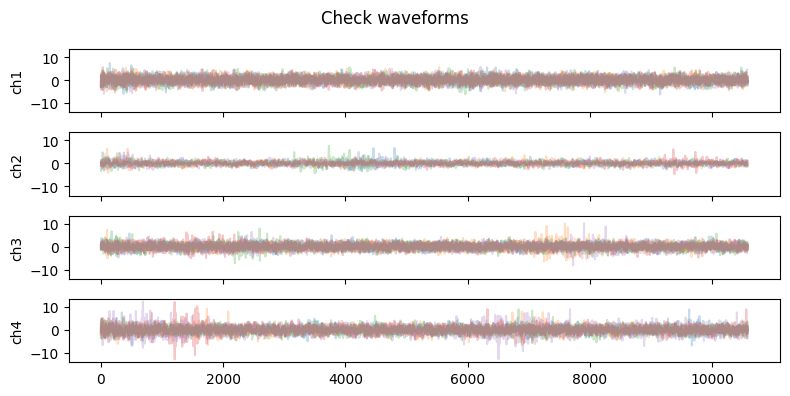

In [456]:
# Select stimulus
myfreq = 100
myamp = 95
current_cond = select_stimulus(cleaned_data, myfreq, myamp)
plot_waveforms(current_cond, channel_keys, title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25)

### Add weights to time domain trials, calculate fft, calculate grand average

In [457]:
weights = [0.25,0.25,0.25,0.25]
weighted_data = add_weights(current_cond, channel_keys, weights)
separated_data = separate_periods(weighted_data, current_cond, period_keys, channel_keys, latency)
weighted_ffts, weighted_freq_vec = compute_fft(separated_data, channel_keys, period_keys, smallest_dim=[], fs=fs)


(<Figure size 800x400 with 8 Axes>,
 array([[<Axes: ylabel='ch1'>, <Axes: ylabel='ch1'>],
        [<Axes: ylabel='ch2'>, <Axes: ylabel='ch2'>],
        [<Axes: ylabel='ch3'>, <Axes: ylabel='ch3'>],
        [<Axes: ylabel='ch4'>, <Axes: ylabel='ch4'>]], dtype=object))

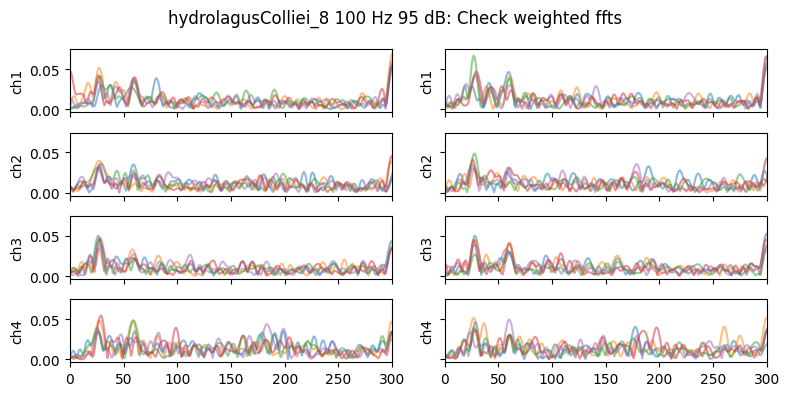

In [458]:
plot_fft(weighted_ffts, weighted_freq_vec, channel_keys, period_keys, myfreq, myamp, subjid, 
         title='Check weighted ffts', 
         num_samples=5, 
         figsize=(8, 4), 
         alpha=0.5, 
         xlim=[0,300])

In [459]:
# diffs = calculate_per_trial_diff(weighted_ffts, channel_keys)
collapsed_dict = collapse_channels(weighted_ffts, period_keys, channel_keys)


In [460]:
bootstrap_means, bootstrap_stds = calculate_bootstrap(
    collapsed_dict, period_keys, 
    n_iterations=1000)

In [461]:
bootstrap_means['prestim']

[array([0.00541903, 0.00553596, 0.00537582, ..., 0.00235601, 0.00234641,
        0.00229443], shape=(11026,)),
 array([0.00539593, 0.00554638, 0.00542059, ..., 0.00235991, 0.00234485,
        0.00229139], shape=(11026,)),
 array([0.00518876, 0.00536534, 0.00530314, ..., 0.00233951, 0.00232393,
        0.0022692 ], shape=(11026,)),
 array([0.00542769, 0.00559505, 0.00548742, ..., 0.00239705, 0.00238216,
        0.00232518], shape=(11026,)),
 array([0.00527815, 0.00542796, 0.00530916, ..., 0.00234591, 0.00233088,
        0.00227479], shape=(11026,)),
 array([0.00530379, 0.00546671, 0.00537908, ..., 0.00239176, 0.00238726,
        0.00233484], shape=(11026,)),
 array([0.00543658, 0.00555928, 0.00539619, ..., 0.00232606, 0.00232315,
        0.00227399], shape=(11026,)),
 array([0.00537962, 0.00552399, 0.00541715, ..., 0.00240759, 0.00239101,
        0.00233328], shape=(11026,)),
 array([0.00536285, 0.00550006, 0.00537692, ..., 0.00234178, 0.00232505,
        0.0022715 ], shape=(11026,)),
 

In [462]:
doub_freq_dict = select_doub_freq_bin(bootstrap_means, weighted_freq_vec, period_keys, myfreq, window_size=100)

(997, 11026)
1000


In [463]:
doub_freq_dict

{'prestim': {'doub_freq_mag': array([0.01064741, 0.01064558, 0.01071089, 0.01066364, 0.01061251,
         0.01047962, 0.01052973, 0.01070083, 0.01060913, 0.01068415,
         0.01071308, 0.01069635, 0.01051242, 0.01063776, 0.01071777,
         0.01064489, 0.01057269, 0.01077854, 0.01065919, 0.01069439,
         0.01064435, 0.01049717, 0.01058206, 0.01051879, 0.01058876,
         0.01058936, 0.01066827, 0.0104533 , 0.01056044, 0.01069507,
         0.01062299, 0.01063997, 0.01084938, 0.01066347, 0.01078434,
         0.01053692, 0.01056367, 0.01076902, 0.01064067, 0.01064255,
         0.01074275, 0.01058375, 0.01057487, 0.01072271, 0.01069683,
         0.01068309, 0.01067095, 0.01053214, 0.01063864, 0.01070307,
         0.01060997, 0.01057382, 0.01076598, 0.01078604, 0.01060023,
         0.01060656, 0.01062231, 0.01060093, 0.01064701, 0.01063592,
         0.01080532, 0.01064718, 0.01067556, 0.01070245, 0.01059703,
         0.01072832, 0.0106315 , 0.01065301, 0.01072153, 0.01062315,
      

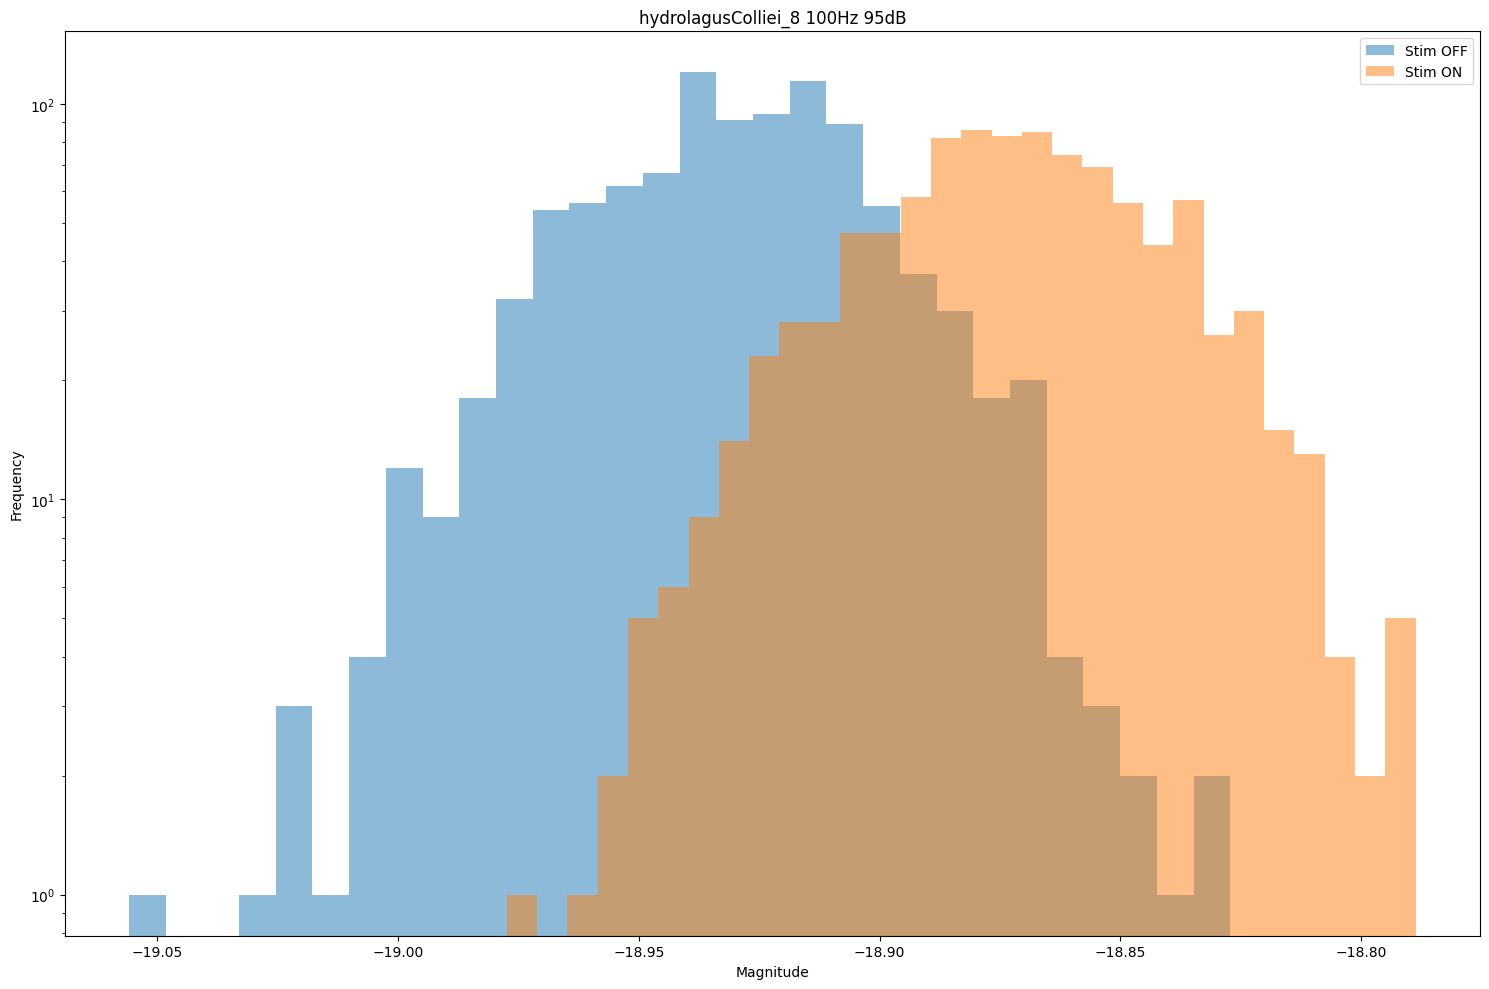

In [464]:
plot_doub_freq_hist(doub_freq_dict, subjid, 'SNR', myfreq, myamp, 30)

In [465]:
diff_CI_results = calculate_diff_CI(doub_freq_dict, 'SNR')

95% CI: (-0.025863463121181863, 0.1408812866491579)
No significant difference (CI includes 0).


### ICA

In [466]:
reshaped_data = reshape_the_data(current_cond, channel_keys)
ica_results = perform_ICA(reshaped_data, channel_keys)
input_data = ica_results['S']
ica_fft_magnitudes, ica_fft_freq_vec = compute_fft(
    input_data, channel_keys=[], period_keys=[], smallest_dim = 1, fs=fs)

Elapsed time: 27.76 seconds
ICA Convergence: 14


In [467]:
plot_waveforms(input_data, channel_keys=[], title='Check ICA Waveforms', num_samples=[], figsize=(8, 4), alpha=1.0)
plot_ffts(ica_fft_magnitudes, ica_fft_freq_vec, subjid, myfreq, myamp, period_keys=[], channel_keys=[], smallest_dim = 0, xlim=[0,300], title = 'ICA FFT')



KeyboardInterrupt: 

In [ ]:
# Denoise/Make best use of all channels
# by applying weights to each channel based on how stable their mean estimate of
# the double frequency response

# Artefact rejection

# Step 1: Add weights to per trial time domain signals by channel 
# Step 2: Conduct ffts on per trial basis on the weighted trials as one mega-channel
# Step 3: In FFT land, calculate the difference between stim and prestim on trial by trial basis
# Step 4: Take the mean on the differences
# Step 5: Calculate the standard deviation as well (optimize around reducing S as much as possible)
# Step 6: Calculate ICA

# After determining weights and performing ICA based denoising...
# Step 6: Bootstrap: Take the data generated from step 2, conduct bootstrap averaging per period, create a distribution of estimates of SNR for each period
# Step 7: 95% CI of the differences between prestim and stimresp


In [ ]:
# Denoise 1: Calculate denoised FFTs
# Calculate FFTs

# Plot prestim/stimresp overlaid
# regular fft works great for us!
cur_fft_prestim = np.mean(per_period_fft['prestim']['ch1'], axis=0)
cur_fft_stimresp = np.mean(per_period_fft['stimresp']['ch1'], axis=0)
plt.plot(per_period_fft_freq['stimresp']['ch1'][0],cur_fft_prestim)
plt.plot(per_period_fft_freq['stimresp']['ch1'][0],cur_fft_stimresp)
plt.xlim([0,500])

#Plot difference ffts
# Create figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Iterate through channels
for i, channel in enumerate(channel_keys):
    # Calculate mean and standard deviation
    cur_fft = np.mean(diff_ffts[channel], axis=0)
    cur_fft_std = np.std(diff_ffts[channel], axis=0)
    
    # Plot on corresponding subplot
    axs[i].plot(per_period_fft_freq['stimresp'][channel][0], cur_fft, label='Mean')
    axs[i].fill_between(per_period_fft_freq['stimresp'][channel][0], 
                        cur_fft - cur_fft_std, 
                        cur_fft + cur_fft_std, 
                        alpha=0.3, 
                        label='±1 Std Dev')
    
    # Set subplot details
    axs[i].set_xlim([0, 500])
    axs[i].set_xlabel('Frequency')
    axs[i].set_ylabel('FFT Magnitude')
    axs[i].set_title(f'Channel {channel} FFT')
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# regular fft works great for us!
cur_fft_prestim = np.mean(per_period_fft['prestim']['ch1'], axis=0)
cur_fft_stimresp = np.mean(per_period_fft['stimresp']['ch1'], axis=0)
plt.plot(per_period_fft_freq['stimresp']['ch1'][0],cur_fft_prestim)
plt.plot(per_period_fft_freq['stimresp']['ch1'][0],cur_fft_stimresp)
plt.xlim([0,500])

NameError: name 'per_period_fft' is not defined